In [1]:
%load_ext autoreload
%autoreload 2


from utils import *

       time  magnitude  parent
0  1.398325   0.463267     0.0
1  1.398325   0.378582     0.0
2  1.491308   0.108758     0.0
3  3.504753   0.161232     0.0
4  4.080534   0.170773     0.0
              time  magnitude   parent
2313     443.48358   4.739052   2312.0
17396   5698.30660   4.348336      0.0
37590  10936.71800   4.229297      0.0
17781   5698.30660   4.182284  17396.0
79473  27267.70300   4.096503  79324.0


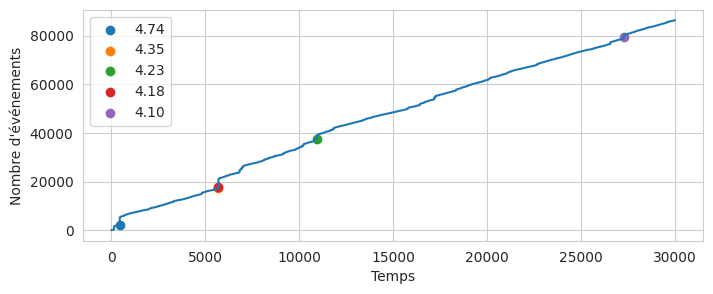

In [22]:
seq = etas(engine='rust', t_end=30000)
df = pd.DataFrame(seq, columns=['time', 'magnitude', 'parent'])
print(df.head())
plt.figure(figsize=(8, 3))
high_mags = df.magnitude.sort_values(ascending=False).index[:5]
print(df.iloc[high_mags])
plt.plot(df.time, df.index + 1)
for idx in high_mags:
    time = df.time.iloc[idx]
    magnitude = df.magnitude.iloc[idx]
    plt.scatter(time, idx + 1, label=f'{magnitude:.2f}')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.savefig('../images/beamer/seq.png', dpi=200, bbox_inches='tight')
plt.show()

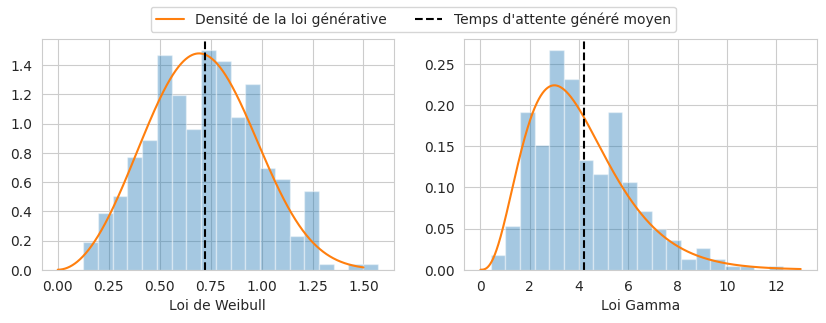

In [15]:
b = 2
k = 3
dist = Weibull(b, k)
arrival_times = np.cumsum(dist.sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

epochs = 100

model = Model(C=32, dist=Weibull, R=3)
history = model.fit(inter_times, seq_lengths, t_end, epochs, verbose=0)
generated_data, seq_lengths = model.generate(1, t_end * 3)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

diff = np.diff(generated_data[0])
axes[0].hist(diff, bins=20, density=True, alpha=0.4)
x = np.linspace(0, 1.5, 1000)
axes[0].plot(x, dist.prob(x), label='Densité de la loi générative')
axes[0].axvline(np.mean(diff), linestyle='--', color='black',
                label='Temps d\'attente généré moyen')
axes[0].set_xlabel('Loi de Weibull')

alpha = 4
beta = 1
dist = Gamma(alpha, beta)
arrival_times = np.cumsum(dist.sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=3)
history = model.fit(inter_times, seq_lengths, t_end, epochs, verbose=0)
generated_data, seq_lengths = model.generate(1, t_end * 3)

diff = np.diff(generated_data[0])
axes[1].hist(diff, bins=20, density=True, alpha=0.4)
x = np.linspace(0, 13, 1000)
axes[1].plot(x, dist.prob(x))
axes[1].axvline(np.mean(diff), linestyle='--', color='black')
axes[1].set_xlabel('Loi Gamma')

fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/beamer/gen_dist_cmp.png', dpi=200,
            bbox_inches='tight')
plt.show()

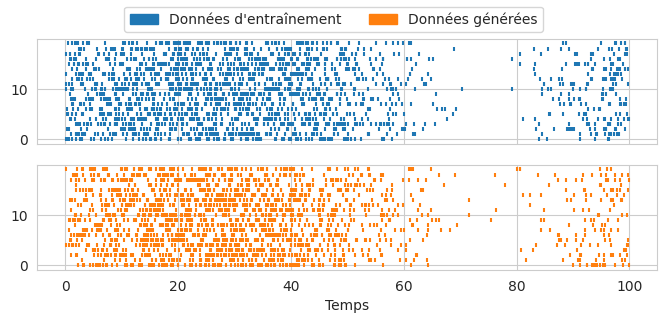

In [25]:
inter_times, seq_lengths, t_end = pickle.load(open('../data/shchur.pkl', 'rb'))
model = Model(C=32, dist=Weibull, R=10)
history = model.fit(inter_times, seq_lengths, t_end, 300, verbose=0)

num_sequences = 20
arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(num_sequences, t_end)

fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

for i, seq in enumerate(arrival_times[:num_sequences]):
    t = seq[:seq_lengths[i]]
    axes[0].scatter(t, np.ones_like(t) * i, marker='|', s=10, c='C0')
left_patch = mpatches.Patch(color='C0', label='Données d\'entraînement')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes[1].scatter(t, np.ones_like(t) * i, marker='|', s=10, c='C1')
axes[1].set_xlabel('Temps')
right_patch = mpatches.Patch(color='C1', label='Données générées')

fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/beamer/gen_data.png', dpi=150, bbox_inches='tight')
plt.show()